# Camera Calibration

Compute the camera calibration matrix and the distortion coefficients given a chessboard image

In [1]:
import os
import cv2
import numpy as np

r = 6
c = 9

# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points
objp = np.zeros((r*c,3), np.float32)
objp[:,:2] = np.mgrid[0:c,0:r].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

image_names = [f for f in os.listdir('camera_cal') if f.endswith('.jpg')]

grayscale_img_size = ()
for fname in image_names:
    img = cv2.imread('camera_cal/'+fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    grayscale_img_size = gray.shape[::-1]
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (c, r), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw the corners
        #img = cv2.drawChessboardCorners(img, (c, r), corners2, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grayscale_img_size, None, None)

Validate the distortion correction on test images

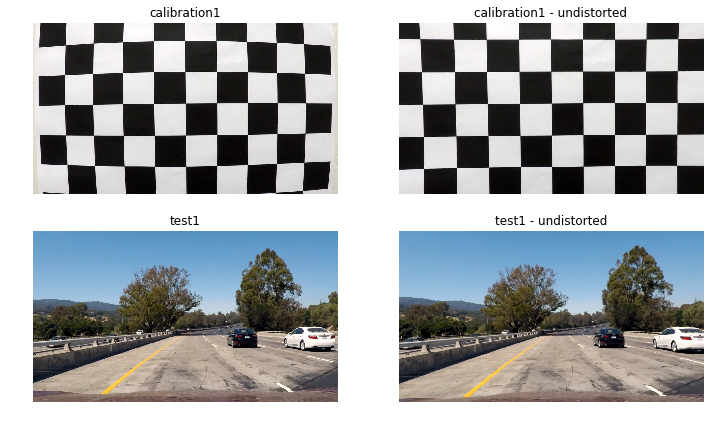

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

#load test images to visualize the distortion correction
img1 = cv2.cvtColor(cv2.imread('camera_cal/calibration1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)

#undistort the images using the camera calibration matrix
undistort1 = cv2.undistort(img1, mtx, dist, None, mtx)
undistort2 = cv2.undistort(img2, mtx, dist, None, mtx)

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.flatten()

axes[0].imshow(img1) 
axes[0].axis('off')
axes[0].set_title('calibration1')

axes[1].imshow(undistort1) 
axes[1].axis('off')
axes[1].set_title('calibration1 - undistorted')

axes[2].imshow(img2) 
axes[2].axis('off')
axes[2].set_title('test1')

axes[3].imshow(undistort2) 
axes[3].axis('off')
axes[3].set_title('test1 - undistorted')

## Color transforms to isolate yellow and white lane lines

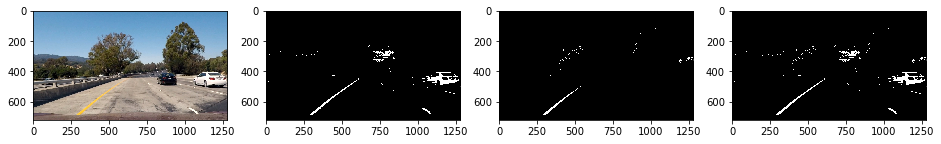

In [3]:
# %pylab inline
# pylab.rcParams['figure.figsize'] = (10, 5)
from pylab import rcParams
rcParams['figure.figsize'] = 16, 4

image = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
plt.subplot(1,4,1)
plt.imshow(image)

#use the HSV image and the white and yellow thresholds from project 1
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

#filter white color
#hsv ranges for white - http://stackoverflow.com/questions/25398188/black-color-object-detection-hsv-range-in-opencv
white_lane_lines = cv2.inRange(hsv_image, np.array([0, 0, 225]), np.array([180, 255, 255]))
plt.subplot(1,4,2)
plt.imshow(white_lane_lines, cmap='gray')

#filter yellow color
#hsv ranges for yellow - http://aishack.in/tutorials/tracking-colored-objects-opencv/
yellow_lane_lines = cv2.inRange(hsv_image, np.array([20, 100, 100]), np.array([80, 255, 255]))
plt.subplot(1,4,3)
plt.imshow(yellow_lane_lines, cmap='gray')

lane_lines = cv2.bitwise_or(white_lane_lines, yellow_lane_lines)
plt.subplot(1,4,4)
plt.imshow(lane_lines, cmap='gray')

## Wrap Perspective i.e. get the "Bird's Eye" view

To simplify computation of the transform matrix use a test image with straight lane lines (straight_lines1.jpg), apply distortion correction on  and manually select the source and destination points

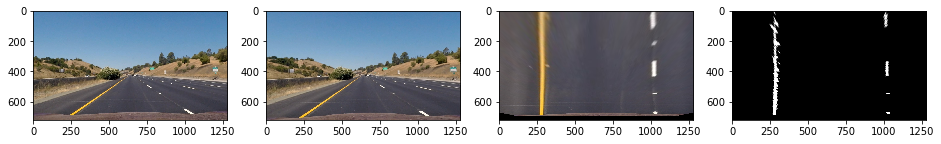

In [4]:
src_pts = np.float32([[270,670],
                         [580,460],
                         [705,460],
                         [1035,670]])
dst_pts = np.float32([[270,670],
                         [270,0],
                         [1035,0],
                         [1035,670]])

image = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)

# undistort the images using the camera calibration matrix
undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# compute perspective transform matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# warp perspective
img_size = undistorted.shape[:2][::-1]
warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)

# warp perpective on filtered lane lines 
# warp perpective on filtered lane lines binary image
hsv_image = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HSV)
white_lane_lines = cv2.inRange(hsv_image, np.array([0, 0, 225]), np.array([180, 255, 255]))
yellow_lane_lines = cv2.inRange(hsv_image, np.array([20, 100, 100]), np.array([80, 255, 255]))
lane_lines = cv2.bitwise_or(white_lane_lines, yellow_lane_lines)
img_size = lane_lines.shape[:2][::-1]
warped_lane_lines = cv2.warpPerspective(lane_lines, M, img_size, flags=cv2.INTER_LINEAR)

plt.subplot(1,4,1)
plt.imshow(image)

plt.subplot(1,4,2)
plt.imshow(undistorted)

plt.subplot(1,4,3)
plt.imshow(warped)

plt.subplot(1,4,4)
plt.imshow(warped_lane_lines, cmap='gray')

## Find Lanes

To find lanes - detect lanes in the first frame of the image and then use this location information in the subsequent frames to narrow/reduce the search space. 

To detect lanes in the first frame we start with the wraped lane lines mask from the prior step. We then compute the column level sum on the subset of the image to identify the location where lane lines are present.

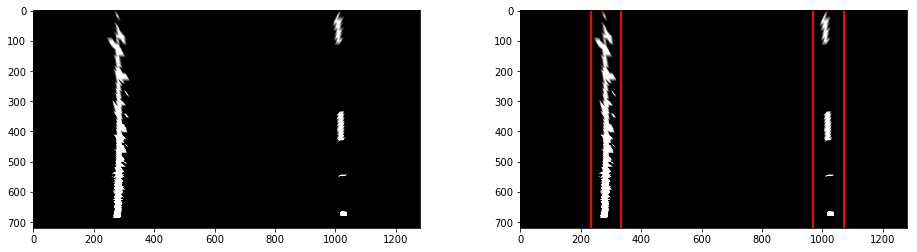

In [5]:
midpoint = np.int(warped_lane_lines.shape[0]/2)
column_histogram = np.sum(warped_lane_lines[midpoint:, :], axis=0)
left_lane_x = np.argmax(column_histogram[0:midpoint])
right_lane_x = np.argmax(column_histogram[midpoint:]) + midpoint

plt.subplot(1,2,1)
plt.imshow(warped_lane_lines, cmap='gray')

lane_lines_search_roi = np.dstack((warped_lane_lines, warped_lane_lines, warped_lane_lines))
cv2.rectangle(lane_lines_search_roi, (left_lane_x-50, 0), (left_lane_x+50, warped_lane_lines.shape[1]), (255, 0, 0), 5)
cv2.rectangle(lane_lines_search_roi, (right_lane_x-50, 0), (right_lane_x+50, warped_lane_lines.shape[1]), (255, 0, 0), 5)

plt.subplot(1,2,2)
plt.imshow(lane_lines_search_roi)

## Fit Lane Lines

Once we determine the approx search region for the first frame we segment the frame into 8 region. For each region we find the points for left lane and right lane and then update the search region based on the point locations. Once all the left lane and right lanes points are identified fit a polynomial

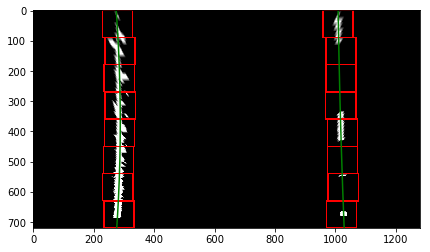

In [6]:
nonzero_pts = warped_lane_lines.nonzero()
nonzero_x = nonzero_pts[1]
nonzero_y = nonzero_pts[0]
#print(nonzero_pts, nonzero_x, nonzero_y)

left_lane_indexes = []
right_lane_indexes = []
lane_lines_fit = np.dstack((warped_lane_lines, warped_lane_lines, warped_lane_lines))
# Step through the segmented reigons if the first frame
for i in range(8):
    # The reigon bounds
    bottom_y = warped_lane_lines.shape[0] - np.int(i * warped_lane_lines.shape[0]/8)
    top_y = warped_lane_lines.shape[0] - np.int((i + 1) * warped_lane_lines.shape[0]/8)
    left_top_x = left_lane_x-50
    left_bottom_x = left_lane_x+50
    right_top_x = right_lane_x-50
    right_bottom_x = right_lane_x+50
    
    #print(top_y, bottom_y)
    #print(left_top_x, left_bottom_x)
    #print(right_top_x, right_bottom_x)
    cv2.rectangle(lane_lines_fit, (left_top_x, top_y), (left_bottom_x, bottom_y), (255, 0, 0), 3)
    cv2.rectangle(lane_lines_fit, (right_top_x, top_y), (right_bottom_x, bottom_y), (255, 0, 0), 3)
    
    # The x/y indexes for left lane
    segment_left_lane_indexes = ((nonzero_y >= top_y) & (nonzero_y < bottom_y) & 
                                (nonzero_x >= left_top_x) & (nonzero_x < left_bottom_x)).nonzero()[0]    
    #the x/y indexes for right lane 
    segment_right_lane_indexes = ((nonzero_y >= top_y) & (nonzero_y < bottom_y) & 
                                (nonzero_x >= right_top_x) & (nonzero_x < right_bottom_x)).nonzero()[0]
    #print(len(segment_left_lane_indexes), len(segment_right_lane_indexes))

    # Update the search reigon location based on found lanes points
    if len(segment_left_lane_indexes) > 50:
        left_lane_x = np.int(np.mean(nonzero_x[segment_left_lane_indexes]))
    if len(segment_right_lane_indexes) > 50:
        right_lane_x = np.int(np.mean(nonzero_x[segment_right_lane_indexes]))
    # Store the non-zero point indexes 
    left_lane_indexes.extend(segment_left_lane_indexes)
    right_lane_indexes.extend(segment_right_lane_indexes)

# Extract left and right line pixel positions
# print(left_lane_indexes, right_lane_indexes)
left_lane_pts_x = nonzero_x[left_lane_indexes]
left_lane_pts_y = nonzero_y[left_lane_indexes] 
right_lane_pts_x = nonzero_x[right_lane_indexes]
right_lane_pts_y = nonzero_y[right_lane_indexes] 

# Fit a second order polynomial to each
left_fit = np.polyfit(left_lane_pts_y, left_lane_pts_x, 2)
right_fit = np.polyfit(right_lane_pts_y, right_lane_pts_x, 2)

# Generate x and y values for plotting
y_values = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_x_values = left_fit[0]*y_values**2 + left_fit[1]*y_values + left_fit[2]
right_x_values = right_fit[0]*y_values**2 + right_fit[1]*y_values + right_fit[2]

plt.imshow(lane_lines_fit)
plt.plot(left_x_values, y_values, color='green')
plt.plot(right_x_values, y_values, color='green')

Now use the polynomial fit equation to find lanes on subsequent frames

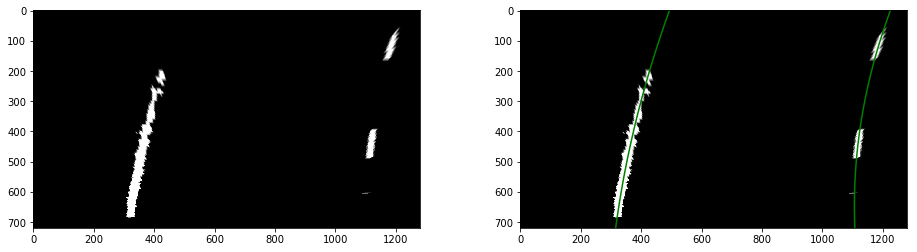

In [9]:
image = cv2.cvtColor(cv2.imread('test_images/test6.jpg'), cv2.COLOR_BGR2RGB)

# undistort the images using the camera calibration matrix
undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# filter lane lines 
hsv_image = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HSV)
white_lane_lines = cv2.inRange(hsv_image, np.array([0, 0, 225]), np.array([180, 255, 255]))
yellow_lane_lines = cv2.inRange(hsv_image, np.array([20, 100, 100]), np.array([80, 255, 255]))
lane_lines = cv2.bitwise_or(white_lane_lines, yellow_lane_lines)

# warp perpective on filtered lane lines binary image
img_size = lane_lines.shape[:2][::-1]
warped_lane_lines = cv2.warpPerspective(lane_lines, M, img_size, flags=cv2.INTER_LINEAR)

plt.subplot(1,2,1)
plt.imshow(warped_lane_lines, cmap='gray')

# use the previously computed polynomial fit equation to isoloate lane pixels
nonzero_pts = warped_lane_lines.nonzero()
nonzero_x = nonzero_pts[1]
nonzero_y = nonzero_pts[0]

left_lane_indexes = []
right_lane_indexes = []

left_lane_indexes = ((nonzero_x > (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] - 100)) &
                     (nonzero_x < (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + 100))) 
right_lane_indexes = ((nonzero_x > (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] - 100)) &
                      (nonzero_x < (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] + 100)))

left_lane_pts_x = nonzero_x[left_lane_indexes]
left_lane_pts_y = nonzero_y[left_lane_indexes] 
right_lane_pts_x = nonzero_x[right_lane_indexes]
right_lane_pts_y = nonzero_y[right_lane_indexes] 

# Fit a second order polynomial to each
left_fit = np.polyfit(left_lane_pts_y, left_lane_pts_x, 2)
right_fit = np.polyfit(right_lane_pts_y, right_lane_pts_x, 2)

# Generate x and y values for plotting
#y_values = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_x_values = left_fit[0]*y_values**2 + left_fit[1]*y_values + left_fit[2]
right_x_values = right_fit[0]*y_values**2 + right_fit[1]*y_values + right_fit[2]

lane_lines_fit = np.dstack((warped_lane_lines, warped_lane_lines, warped_lane_lines))
plt.subplot(1,2,2)
plt.imshow(lane_lines_fit)
plt.plot(left_x_values, y_values, color='green')
plt.plot(right_x_values, y_values, color='green')

## Compute the Lane Curvature and the position of the vehicle

We compute the left and the right curvature based on below equation:
http://www.intmath.com/applications-differentiation/8-radius-curvature.php
The overall curvature is determined by averaging the left and right values

To compute the vehicle position
- average the X intercept for both the left and right lanes
- find the distance of the avg. x intercept value from center of image
- convert the distance from center from pixels to meters by multiplying with the ration 3.7m/700px


In [10]:
ym_per_pix = 30./720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension
left_fit_cr = np.polyfit(y_values*ym_per_pix, left_x_values*xm_per_pix, 2)
right_fit_cr = np.polyfit(y_values*ym_per_pix, right_x_values*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*np.max(y_values)*ym_per_pix + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*np.max(y_values)*ym_per_pix + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
    
    
# Calculate the position of the vehicle
left_x_intercept =  left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]
right_x_intercept = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]
vehicle_offset = (img_size[0]/2 - ((left_x_intercept+right_x_intercept)/2)) * xm_per_pix

print(left_curverad, right_curverad, left_x_intercept, right_x_intercept, vehicle_offset)

1046.47716362 577.111874484 315.269624281 1107.20837542 -0.376548999216


## Output the detected lane lines, vehicle position/curvature information on the original frame

Warp the computed lane lines back to the orginial image using the inverse warp perspective matrix.

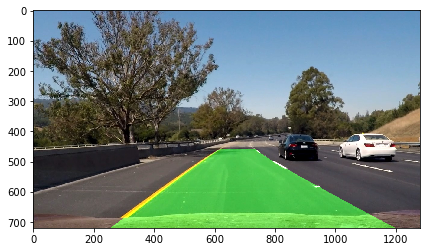

In [12]:
# Recast the x and y points into usable format for cv2.fillPoly()
left_pts = np.array([np.transpose(np.vstack([left_x_values, y_values]))])
right_pts = np.array([np.flipud(np.transpose(np.vstack([right_x_values, y_values])))])
pts = np.hstack((left_pts, right_pts))

empty_img = np.zeros_like(warped_lane_lines).astype(np.uint8)
lane_lines_filled = np.dstack((empty_img, empty_img, empty_img))
cv2.fillPoly(lane_lines_filled, np.int_([pts]), (0,255, 0))

# Compute inverse perspective transform matrix
Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)

# Warp the filled lane line back to the original image
lane_lines_warped = cv2.warpPerspective(lane_lines_filled, Minv, (img_size[0], img_size[1]))

# Merge the result 
result = cv2.addWeighted(image, 1, lane_lines_warped, 0.5, 0)
plt.imshow(result)